In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage.feature
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
r = 0.4
width = 100

In [3]:
def GetData(filename):
    # read the Train and Train Dotted images
    image_1 = cv2.imread("../Desktop/input/TrainDotted/" + filename)
    image_2 = cv2.imread("../Desktop/input/Train/" + filename)
    img1 = cv2.GaussianBlur(image_1,(5,5),0)

    # absolute difference between Train and Train Dotted
    image_3 = cv2.absdiff(image_1,image_2)
    mask_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
    mask_1[mask_1 < 50] = 0
    mask_1[mask_1 > 0] = 255
    image_4 = cv2.bitwise_or(image_3, image_3, mask=mask_1)

    # convert to grayscale to be accepted by skimage.feature.blob_log
    image_6 = np.max(image_4,axis=2)

    # detect blobs
    blobs = skimage.feature.blob_log(image_6, min_sigma=3, max_sigma=7, num_sigma=1, threshold=0.05)

    h,w,d = image_2.shape

    res=np.zeros((int((w*r)//width)+1,int((h*r)//width)+1,1), dtype='int16')

    for blob in blobs:
        # get the coordinates for each blob
        y, x, s = blob
        # get the color of the pixel from Train Dotted in the center of the blob
        b,g,R = img1[int(y)][int(x)][:]
        x1 = int((x*r)//width)
        y1 = int((y*r)//width)
        # decision tree to pick the class of the blob by looking at the color in Train Dotted
        if R > 225 and b < 25 and g < 25: # RED
            res[x1,y1,0]+=1

    ma = cv2.cvtColor((1*(np.sum(image_1, axis=2)>20)).astype('uint8'), cv2.COLOR_GRAY2BGR)
    img = cv2.resize(image_2 * ma, (int(w*r),int(h*r)))
    h1,w1,d = img.shape

    trainX = []
    trainY = []

    for i in range(int(w1//width)):
        for j in range(int(h1//width)):
            trainY.append(res[i,j,:])
            trainX.append(img[j*width:j*width+width,i*width:i*width+width,:])

    return np.array(trainX), np.array(trainY)

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [12]:
trainX, trainY = GetData("15Sep.JPG")

np.random.seed(1004)
randomize = np.arange(len(trainX))
np.random.shuffle(randomize)
trainX = trainX[randomize]
trainY = trainY[randomize]

n_train = int(len(trainX) * 0.7)
testX = trainX[n_train:]
testY = trainY[n_train:]
trainX = trainX[:n_train]
trainY = trainY[:n_train]

print(trainY.shape, trainY[0])
print(testY.shape, testY[0])

(134, 1) [19]
(58, 1) [8]


[[19]
 [16]
 [14]
 [ 6]]


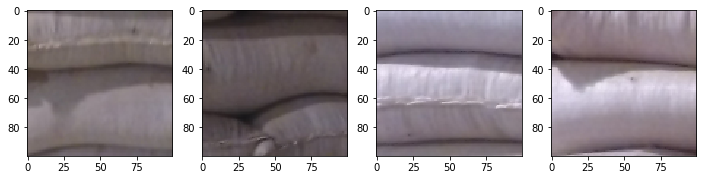

In [13]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    ax = fig.add_subplot(1,4,i+1)
    plt.imshow(cv2.cvtColor(trainX[i], cv2.COLOR_BGR2RGB))
print(trainY[:4])

In [14]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(width,width,3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='linear'))

#model.summary()

In [15]:
optim = keras.optimizers.SGD(lr=1e-5, momentum=0.2)
model.compile(loss='mean_squared_error', optimizer=optim)
model.fit(trainX, trainY, epochs=10, verbose=2)

Epoch 1/10
 - 0s - loss: 465.0055
Epoch 2/10
 - 0s - loss: 19.8003
Epoch 3/10
 - 0s - loss: 19.2321
Epoch 4/10
 - 0s - loss: 18.5780
Epoch 5/10
 - 0s - loss: 21.9263
Epoch 6/10
 - 0s - loss: 19.1374
Epoch 7/10
 - 0s - loss: 19.2438
Epoch 8/10
 - 0s - loss: 19.1877
Epoch 9/10
 - 0s - loss: 18.0342
Epoch 10/10
 - 0s - loss: 23.3045


In [16]:
optim = keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer=optim)

In [17]:
model.fit(trainX, trainY, epochs=200, verbose=2)

Epoch 1/200
 - 0s - loss: 61.5747
Epoch 2/200
 - 0s - loss: 40.7025
Epoch 3/200
 - 0s - loss: 34.4110
Epoch 4/200
 - 0s - loss: 48.4525
Epoch 5/200
 - 0s - loss: 36.2875
Epoch 6/200
 - 0s - loss: 36.0280
Epoch 7/200
 - 0s - loss: 35.3667
Epoch 8/200
 - 0s - loss: 34.3269
Epoch 9/200
 - 0s - loss: 31.8852
Epoch 10/200
 - 0s - loss: 25.4348
Epoch 11/200
 - 0s - loss: 22.5093
Epoch 12/200
 - 0s - loss: 22.3513
Epoch 13/200
 - 0s - loss: 20.0352
Epoch 14/200
 - 0s - loss: 19.9715
Epoch 15/200
 - 0s - loss: 20.1868
Epoch 16/200
 - 0s - loss: 20.0208
Epoch 17/200
 - 0s - loss: 21.5455
Epoch 18/200
 - 0s - loss: 19.8647
Epoch 19/200
 - 0s - loss: 20.3534
Epoch 20/200
 - 0s - loss: 19.6901
Epoch 21/200
 - 0s - loss: 19.6614
Epoch 22/200
 - 0s - loss: 19.6737
Epoch 23/200
 - 0s - loss: 21.2033
Epoch 24/200
 - 0s - loss: 20.5419
Epoch 25/200
 - 0s - loss: 20.6050
Epoch 26/200
 - 0s - loss: 19.2047
Epoch 27/200
 - 0s - loss: 20.4025
Epoch 28/200
 - 0s - loss: 19.7649
Epoch 29/200
 - 0s - loss: 19

In [10]:
model.fit(trainX, trainY, epochs=200, verbose=2)

Epoch 1/200
 - 0s - loss: 1.3919
Epoch 2/200
 - 0s - loss: 1.4771
Epoch 3/200
 - 0s - loss: 1.4771
Epoch 4/200
 - 0s - loss: 1.5059
Epoch 5/200
 - 0s - loss: 1.7841
Epoch 6/200
 - 0s - loss: 2.6801
Epoch 7/200
 - 0s - loss: 3.4652
Epoch 8/200
 - 0s - loss: 1.3277
Epoch 9/200
 - 0s - loss: 1.2571
Epoch 10/200
 - 0s - loss: 1.6672
Epoch 11/200
 - 0s - loss: 1.3164
Epoch 12/200
 - 0s - loss: 0.9409
Epoch 13/200
 - 0s - loss: 1.2022
Epoch 14/200
 - 0s - loss: 1.2909
Epoch 15/200
 - 0s - loss: 1.4255
Epoch 16/200
 - 0s - loss: 1.5112
Epoch 17/200
 - 0s - loss: 3.4193
Epoch 18/200
 - 0s - loss: 1.3842
Epoch 19/200
 - 0s - loss: 1.1842
Epoch 20/200
 - 0s - loss: 1.5813
Epoch 21/200
 - 0s - loss: 2.4205
Epoch 22/200
 - 0s - loss: 1.8074
Epoch 23/200
 - 0s - loss: 1.2686
Epoch 24/200
 - 0s - loss: 1.2935
Epoch 25/200
 - 0s - loss: 0.7816
Epoch 26/200
 - 0s - loss: 0.6817
Epoch 27/200
 - 0s - loss: 0.7046
Epoch 28/200
 - 0s - loss: 0.7785
Epoch 29/200
 - 0s - loss: 1.3012
Epoch 30/200
 - 0s - lo

In [18]:
result = model.predict(trainX)
print('Training set --')
print('    ground truth: ', np.sum(trainY, axis=0))
print('  evaluate count: ', np.sum(result*(result>0.5), axis=0).astype('int'))

result = model.predict(testX)
print('Testing set --')
print('    ground truth: ', np.sum(testY, axis=0))
print('   predict count: ', np.sum(result*(result>0.5), axis=0).astype('int'))

Training set --
    ground truth:  [481]
  evaluate count:  [476]
Testing set --
    ground truth:  [128]
   predict count:  [148]
